In [3]:
from netCDF4 import Dataset
from calendar import monthrange
from cartoplot import cartoplot
import mask
import numpy as np
from field_importer import get_field
from regrid import regrid
import os
import xarray as xr
import subprocess
import tqdm
import shutil


/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


# Data downloader

In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'satellite-sea-ice-edge-type',
    {
        'version': '1_0',
        'format': 'zip',
        'cdr_type': 'icdr',
        'variable': 'sea_ice_type',
        'region': 'northern_hemisphere',
        'month': [
            '01', '02', '03',
            '04', '10', '11',
            '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'year': [
            '2018', '2019', '2020',
        ],
    },
    'cds_interim_type.zip')

2021-05-19 16:41:12,539 INFO Welcome to the CDS
2021-05-19 16:41:12,540 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-ice-edge-type
2021-05-19 16:41:12,638 INFO Request is queued
2021-05-19 16:41:15,193 INFO Request is running
2021-05-19 16:55:31,539 INFO Request is completed
2021-05-19 16:55:31,540 INFO Downloading https://download-0013.copernicus-climate.eu/cache-compute-0013/cache/data5/dataset-satellite-sea-ice-edge-type-6726e31c-150c-45e1-ae3b-5ca21baa8719.zip to cds_interim_type.zip (627.4M)
2021-05-19 16:57:35,156 INFO Download rate 5.1M/s  


Result(content_length=657843599,content_type=application/zip,location=https://download-0013.copernicus-climate.eu/cache-compute-0013/cache/data5/dataset-satellite-sea-ice-edge-type-6726e31c-150c-45e1-ae3b-5ca21baa8719.zip)

In [7]:
directory = '/home/robbie/Dropbox/SM_Thickness/data/CDS_type'
destination = '/home/robbie/Dropbox/SM_Thickness/data/CDS_type/monmeans'
dest2 = '/home/robbie/Dropbox/SM_Thickness/data/CDS_type/monmeans/432'

# First iterate through the years where OSISAF data is available

for subdir in tqdm.tqdm(os.listdir(directory)):
    
    # Print the year
    
    print(subdir)
    
    # One directory doesn't correspond to a year, but instead to monthly means. Ignore thyis
    
    if (subdir != 'raw') and (subdir != 'monmeans') and (subdir == '2020'):
        
        # For a given year, iterate through the months inside
        
        for monthdir in os.listdir(directory + '/' + subdir):
            
            print(monthdir)

#             Choose the month name

            os.chdir(directory + '/' + subdir + '/' + monthdir)

            # This puts all the netcdfs into one, daily file

            p = subprocess.Popen(['cdo', 'mergetime', '*.nc', 'timeseries.nc' ])

            p.wait()

            # This averages that single daily file into a new monthly mean file

            p = subprocess.Popen(['cdo', 'monmean', 'timeseries.nc', f'{subdir}_{monthdir}_monthlymean.nc'])

            p.wait()

            shutil.move(f'{directory}/{subdir}/{monthdir}/{subdir}_{monthdir}_monthlymean.nc',f'{dest2}/{subdir}_{monthdir}_monthlymean.nc')


  0%|          | 0/22 [00:00<?, ?it/s]

2009
raw
2019
2012
2011
2006
2018
2015
2014
2020
02
01
10
03
11
04
12


100%|██████████| 22/22 [00:05<00:00,  4.38it/s]

2017
2007
monmeans
2010
2016
2002
2008
2003
2013
2005
2004
cds_interim_type


In [8]:
yearlist = np.arange(2020,2021)
# yearlist = [2011]

monthlist_2002 = ["03","04","10","11","12"]
monthlist_full = ["01","02","03","04","10","11","12"]
# monthlist_full = ['11']

W99_OSISAF = {"depth":{},"density":{},"SWE":{}}

lon_target, lat_target = mask.get('lon'),mask.get('lat')

for year in tqdm.tqdm(yearlist):
    
    if year == 2002:
        monthlist = monthlist_2002
    else:
        monthlist = monthlist_full
    
    for month in monthlist:
        
        data = get_field('cds',month,year,variable='type',resolution=432)
        
        if (month == '11') and (year == 2011): data['field'] = data['field'][0]
        
        data_361 = regrid(data['field'],data['lon'],data['lat'],lon_target,lat_target)
        
        output = {'field':data_361,'lon':lon_target,'lat':lat_target}
        
        att_dict = {'title': 'Monthly sea ice type data regridded on 361x361 EASE grid',
                    'month': f'{month}',
                    'year':f'{year}'}
        
        ds = xr.Dataset( data_vars={'ice_type':(['x','y'],output['field'])},
                             coords={'lon':(['x','y'],output['lon']),
                                     'lat':(['x','y'],output['lat'])},
                             attrs=att_dict)
        
        ds.to_netcdf(f'/home/robbie/Dropbox/SM_Thickness/data/CDS_type/monmeans/361/{year}_{month}_monthlymean.nc','w')

100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


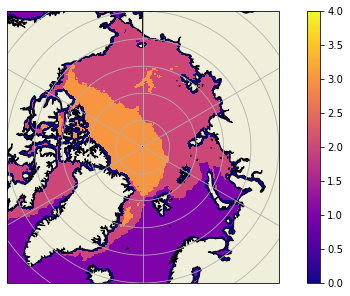

In [9]:
CDS_t = get_field('cds',"12",2020,variable='type',resolution=361)

# OSI_t = get_field('osisaf',"12",2020,variable='type',resolution=361)


cartoplot(CDS_t['lon'],CDS_t['lat'],CDS_t['field'],color_scale=(0,4))
# cartoplot(OSI_t['lon'],OSI_t['lat'],OSI_t['field'],color_scale=(0,4))

In [2]:
from netCDF4 import Dataset
data = Dataset('/home/robbie/Dropbox/SM_Thickness/data/CDS_type/monmeans/2003_11_monthlymean.nc')
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history: Tue Mar 17 19:17:06 2020: cdo monmean timeseries.nc 2003_11_monthlymean.nc
Tue Mar 17 19:17:06 2020: cdo mergetime *.nc timeseries.nc
20180615T213526Z (created)
    source: FCDR of SMMR / SSMI / SSMIS Brightness Temperatures R3 (doi: 10.5676/EUM_SAF_CM/FCDR_MWI/V003),ERA-Interim fields from ECMWF (doi: 10.1002/qj.828),EUMETSAT OSI SAF Sea Ice Concentration v2p0 (doi: 10.15770/EUM_SAF_OSI_0008)
    institution: Norwegian Meteorological Institute
    Conventions: CF-1.6 ACDD-1.3
    title: Sea Ice Type
    summary: Daily gridded Level-3 Sea Ice Type Climate Data Record (CDR) from passive microwave satellite data (SMMR, SSM/I, and SSMIS) for the period January 1979 - December 2015. The processing chain features: 1) correction of atmospheric noise using a Radiative Transfer Model, 2) dynamic tuning of algorithms fro

In [6]:

year = 2002
file = f'iceage_nh_12.5km_{year}0101_{year}1231_v4.1.nc'

data = Dataset(data_dir+file)

In [7]:
monthlist = list(range(1,13))

days_in_month = {}

for monthnum in monthlist:
    days = monthrange(year, monthnum)[1]
    days_in_month[monthnum] = days
    
print(days_in_month)

{1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}


In [9]:
remainder = 0

for month in days_in_month.keys():
    
    days_in = days_in_month[month] - (7-remainder)
    
    remainder = days_in%7
    
    month ave = first four months plus remainder. 

1 31 3
2 28 0
3 31 3
4 30 2
5 31 3
6 30 2
7 31 3
8 31 3
9 30 2
10 31 3
11 30 2
12 31 3
